In [21]:
import numpy as np
import scipy
import time
import numba
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [23]:
### For a given growth rate, find the solution of Eq. (12) of the SM

def f(m1, r1, gamma1):
    
    z = 0.5*(r1-gamma1)**2

    numerator = 2*(r1-gamma1)*scipy.special.gamma(1 + m1*gamma1/ 2)*scipy.special.hyp1f1(1 + m1*gamma1/2, 1.5, z) + np.sqrt(2)*scipy.special.gamma(1/2 + m1*gamma1/2)*scipy.special.hyp1f1(1/2 + m1*gamma1/2, 1/2, z)

    denominator = scipy.special.gamma(m1*gamma1/2)*scipy.special.hyp1f1(m1*gamma1/2, 1/2, z) + np.sqrt(2)*(r1 - gamma1)*scipy.special.gamma(1/2 + m1*gamma1/2)*scipy.special.hyp1f1(1/2 + m1*gamma1/2, 3/2, z)
    
    return numerator/denominator - m1

def mean_finder(r1, gamma1):
    sol = root_scalar(f, args=(r1, gamma1), bracket=[1e-12, 5*r1], method='brentq')
    return sol.root

In [25]:
### Value of the coupling constant between sites
gamma = 2 

### Value of the critical growth rate below which the species gets extinct at late times
rc = 0.4281423116229064

### Possible values of dr = r - rc and the associated average population size, solution of Eq. (12) of the SM
dr = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])
m = np.zeros(len(dr))

for k in range(len(dr)):
    m[k] = mean_finder(rc + dr[k], gamma)

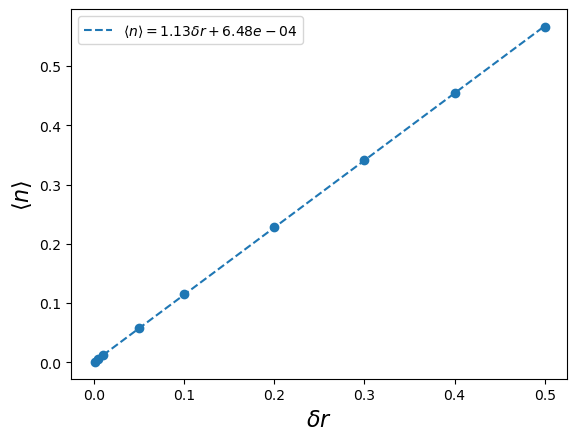

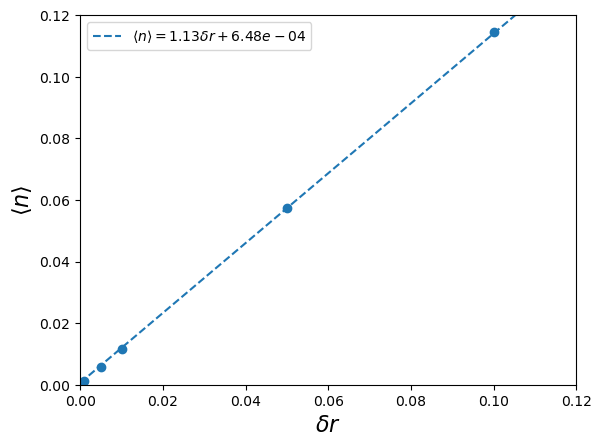

In [27]:
### Check the linear scaling of the mean population size with the distance to the critical point

plt.scatter(dr, m)
a, b = np.polyfit(dr, m, 1)

x = np.linspace(0, 0.5, 100)
plt.plot(x, a*x + b, linestyle = 'dashed', label = fr'$\left\langle n \right\rangle ={a:.2f}\delta r +{b:.2e}$')
plt.ylabel(r'$\left\langle n \right\rangle$', fontsize = 16)
plt.xlabel(r'$\delta r$', fontsize = 16)
plt.legend()
plt.show()

plt.scatter(dr, m)
x = np.linspace(0, 0.5, 100)
plt.plot(x, a*x + b, linestyle = 'dashed', label = fr'$\left\langle n \right\rangle ={a:.2f}\delta r +{b:.2e}$')
plt.ylabel(r'$\left\langle n \right\rangle$', fontsize = 16)
plt.xlabel(r'$\delta r$', fontsize = 16)
plt.legend()
plt.xlim(0, 0.12)
plt.ylim(0, 0.12)
plt.show()

In [29]:
### Equilibration: N copies

def init(m1, r1, gamma1, N, T, dt):

    t_int = np.linspace(0,T,int(T/dt))

    traj = np.zeros((N, int(T/dt)))

    for k in range(int(T/dt) - 1):

        evol_stoch_poisson = np.random.poisson(traj[:, k]/dt) 

        evol_stoch = np.random.gamma(evol_stoch_poisson, scale=1.0)*dt

        traj[:,k+1] = evol_stoch + dt*(evol_stoch*(r1 - evol_stoch) + gamma1*(m1 - evol_stoch))

    mean_empirical = np.mean(traj, axis = 0)
    std_empirical = np.std(traj, axis = 0)
    
    return mean_empirical, std_empirical, traj[:,-1]  

In [31]:
### Check initialization for different values of dr

gamma = 2 
rc = 0.428142
dr = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])
m = np.array([0.00115022, 0.00575033, 0.0114987, 0.0574178, 0.114649, 0.228567, 0.341792, 0.454358, 0.566299])

for k in range(9):
    
    T = 20
    dt = 1e-3
    t_int = np.linspace(0,T,int(T/dt))

    mean = np.zeros(int(T/dt))
    std = np.zeros(int(T/dt))

    for j in range(10):
        mean_temp, std_temp, final_cond = init(m[k], rc + dr[k], 2, 1_000, T, dt)
        mean += mean_temp/10
        std += std_temp/10

    plt.plot(t_int, mean/m[k])
    plt.axhline(1, linestyle = 'dashed')
    plt.title(r'Mean $\delta r =$' f'{dr[k]}')
    plt.show()

    plt.plot(t_int, std)
    plt.title(r'Standard deviation $\delta r =$' f'{dr[k]}')
    plt.show()

KeyboardInterrupt: 

In [34]:
### Correlations

def correlation(m1, r1, gamma1, N, T, dt):

    t_int = np.linspace(0,T,int(T/dt))

    traj = np.zeros((N, int(T/dt)))

    T_init = 20

    mean_temp, std_temp, init_cond = init(m1, r1, gamma1, N, T_init, dt)

    traj[:,0] = init_cond

    for k in range(int(T/dt) - 1):

        evol_stoch_poisson = np.random.poisson(traj[:, k]/dt) 

        evol_stoch = np.random.gamma(evol_stoch_poisson, scale=1.0)*dt

        traj[:,k+1] = evol_stoch + dt*(evol_stoch*(r1 - evol_stoch) + gamma1*(m1 - evol_stoch))

    mean_empirical = np.mean(traj, axis = 0)
    correl = np.mean(init_cond[:, np.newaxis]*traj, axis = 0)
    
    return mean_empirical, correl    

In [36]:
### Measure of correlations for different values of dr

gamma = 2 
rc = 0.428142
dr = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])
m = np.array([0.00115022, 0.00575033, 0.0114987, 0.0574178, 0.114649, 0.228567, 0.341792, 0.454358, 0.566299])

T = 20
dt = 1e-3

t_int = np.linspace(0,T,int(T/dt))

correl_vec = np.zeros((9, len(t_int)))

for k in range(9):
    
    T = 20
    t_int = np.linspace(0,T,int(T/dt))

    mean = np.zeros(int(T/dt))
    std = np.zeros(int(T/dt))
    
    Q = 1_000

    for j in range(Q):
        mean_temp, correl_temp = correlation(m[k], rc + dr[k], 2, 1_000, T, dt)
        correl_vec[k] += correl_temp/Q
        
    plt.title(r'Correlations $\delta r =$' f'{dr[k]}')

    plt.plot(np.linspace(0,T,int(T/dt)), correl_vec[k])
    plt.axhline(y = 0, linestyle = 'dashed')
    plt.axhline(y = m[k]**2, linestyle = 'dashed')
    plt.show()

KeyboardInterrupt: 